In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import signal
from mi_estimators import *
import sklearn.preprocessing as sklp
from tqdm import trange
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


In [81]:
class ConvolutionSampler(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=False, padding='same')
        
        t = torch.arange(0, 100)
        tau1 = 5
        tau2 = 15
        k1 = torch.flip(torch.exp(-t/tau1), dims=[-1])
        k2 = torch.flip(torch.exp(-t/tau2), dims=[-1])
        
        
        for param in self.conv.parameters():
            param.data = torch.stack((k1, k2)).unsqueeze(1)
            
        self.W = torch.nn.Parameter(torch.tensor([[1.0, 1.5], [1.3, 0.75]], requires_grad = True))

    def forward(self, x):
        y = self.conv(x).double()
        return y.squeeze(0).T.double() @ self.W.double()

In [82]:
def gen_sine_wave(t, A, w, phase, baseline, sigma):
    noise = np.random.normal(0, sigma, len(t))
    y = A*np.sin(w*t + phase) + noise + baseline
    return y

def gen_square_wave(t, A, w, phase, baseline, sigma):
    noise = np.random.normal(0, sigma, len(t))
    y = A*signal.square(w*t + phase) + baseline + noise
    return y

In [178]:
t = np.linspace(0, 20, 100000)
sine = gen_sine_wave(t, A=1, w=2*np.pi/2, phase=0, baseline=0, sigma=0.25)
square = gen_square_wave(t, A=1, w=2*np.pi/5, phase=np.pi/2, baseline=0, sigma=0.25)

square = torch.tensor(square)
sine = torch.tensor(sine)
inputs = torch.stack((square, sine))
inputs.unsqueeze(0).size()

torch.Size([1, 2, 100000])

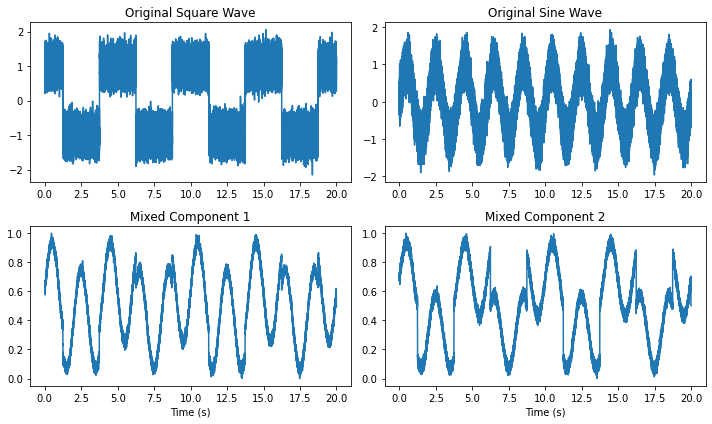

In [179]:
sampler = ConvolutionSampler()
y = sampler(inputs.unsqueeze(0).float())

plt.figure(figsize=(10,6))

plt.subplot(2, 2, 1)
plt.title('Original Square Wave')
plt.plot(t, inputs[0,:])

plt.subplot(2, 2, 2)
plt.title('Original Sine Wave')
plt.plot(t, inputs[1, :])

plt.subplot(2,2,3)
plt.title('Mixed Component 1')
plt.plot(t, sklp.minmax_scale(y[:, 0].detach().numpy()))
plt.xlabel('Time (s)')

plt.subplot(2,2,4)
plt.title('Mixed Component 2')
plt.plot(t, sklp.minmax_scale(y[:, 1].detach().numpy()))
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('time_dept_signal_convolutive_mixing2.jpeg')

In [180]:
class ConvolutiveDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv =  nn.Conv1d(2, 2, kernel_size=100, groups=2, bias=True, padding='same')
        
        #t = torch.arange(0, 100)
        #k1 = torch.flip(torch.exp(-t), dims=[-1])
        #k2 = torch.flip(torch.exp(-t), dims=[-1])
        
        
        #for param in self.conv.parameters():
            #param.data = torch.stack((k1, k2)).unsqueeze(1)
        
        self.lin = nn.Linear(2, 2, bias=True)
        
    def forward(self, x_samples, y_samples):
        samples = torch.stack((x_samples, y_samples), dim=1)
        samples = samples.T.unsqueeze(0)
        samples_out = self.conv(samples)
        samples_out = samples_out.squeeze(0).T
        samples_out = self.lin(samples_out)
        return samples_out[:, 0], samples_out[:, 1]

In [181]:
def signal_clarity(sources, inputs):
    r = np.corrcoef(sources, inputs)
    c = np.absolute(np.diff(np.absolute(r), axis=0))
    return np.mean(c)

In [183]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient']

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_31256/153410125.py, line 27)

In [202]:
def train_model(data, lr, batch_size, num_epochs, num_mini_batches, schedule):

    sample_dim = 1
    hidden_size = 25

    decoder = ConvolutiveDecoder().to(dev)
    mi_estimator = CLUBSample(1, 1, hidden_size).to(dev)

    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr = lr)
    mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

    
    if schedule is True:
        decoder_scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma=0.999)
        mi_scheduler = torch.optim.lr_scheduler.ExponentialLR(mi_optimizer, gamma=0.999)

    mi_est_values = []
    clarity_est = []
    
    num_batches = len(data[:, 0]) // batch_size
    print('num:', num_batches)
    
    data_len = len(data[:, 0])

    
    x_samples = data[:, 0]
    y_samples = data[:, 1]
    for epoch in trange(num_epochs):

        #random_indx = np.random.randint(num_batches, size=2)
        random_indx = np.random.randint(data_len-batch_size, size=2)
        n = random_indx[0]
        m = random_indx[1]

        x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())

        #x_samples_out = x_samples_out[n*batch_size : n*batch_size+batch_size]
        #y_samples_out = y_samples_out[m*batch_size : m*batch_size+batch_size]
        x_samples_out = x_samples_out[n : n + batch_size]
        y_samples_out = y_samples_out[m : m + batch_size]

        decoder_loss = mi_estimator(x_samples_out.unsqueeze(0).T, y_samples_out.unsqueeze(0).T)
        decoder_optimizer.zero_grad()
        decoder_loss.backward(retain_graph=True)
        plot_grad_flow(decoder.named_parameters())
        decoder_optimizer.step()
        
        mi_est_values.append(decoder_loss.cpu().detach().numpy())
        #if np.absolute(decoder_loss.cpu().detach().numpy())<1e-12:
                #break
        
        for i in range(num_mini_batches):
            
            #random_indx = np.random.randint(num_batches, size=2)
            random_indx = np.random.randint(data_len-batch_size, size=2)
            n = random_indx[0]
            m = random_indx[1]

            x_samples_out, y_samples_out = decoder(x_samples.float(), y_samples.float())

            #x_samples_out = x_samples_out[n*batch_size : n*batch_size+batch_size]
            #y_samples_out = y_samples_out[m*batch_size : m*batch_size+batch_size]
            x_samples_out = x_samples_out[n : n + batch_size]
            y_samples_out = y_samples_out[m : m + batch_size]

            mi_loss = mi_estimator.learning_loss(x_samples_out.unsqueeze(0).T.detach(), y_samples_out.unsqueeze(0).T.detach())
            mi_optimizer.zero_grad()
            mi_loss.backward()
            mi_optimizer.step()
            
        if schedule is True: 
            #mi_scheduler.step()
            decoder_scheduler.step()
    
    
        x_samples, y_samples = decoder(data[:, 0].float(), data[:, 1].float())
        recovered = np.vstack((sklp.minmax_scale(x_samples.cpu().detach().numpy()), sklp.minmax_scale(y_samples.cpu().detach().numpy())))
        original = sklp.minmax_scale(inputs.T).T
        clarity_est.append(signal_clarity(original, recovered))

    return mi_est_values, clarity_est, x_samples.cpu().detach().numpy(), y_samples.cpu().detach().numpy(), decoder
    

In [ ]:
y = y.to(dev)
num_mini_batches = 5000
lr=1e-4
batch_size = 10000 # equal to the length of the input
num_epochs = 50
schedule = False

mi_est_values, clarity_est, x_samples, y_samples, decoder = train_model(data=y, lr=lr, batch_size=batch_size, num_epochs=num_epochs, num_mini_batches=num_mini_batches, schedule=schedule)

num: 10


 34%|███▍      | 17/50 [02:29<04:52,  8.86s/it]

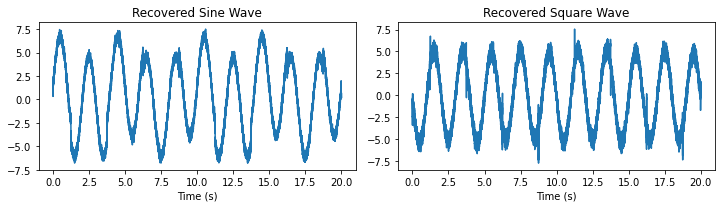

In [207]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title('Recovered Sine Wave')
plt.plot(t, x_samples)

plt.xlabel('Time (s)')

plt.subplot(1, 2, 2)
plt.plot(t, y_samples)
plt.title('Recovered Square Wave')
plt.xlabel('Time (s)')

plt.tight_layout()
plt.savefig('recovered_components_convolution5.jpeg')

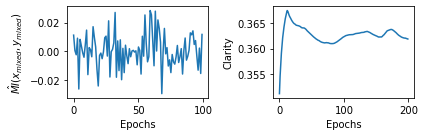

In [209]:
plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
plt.plot(mi_est_values[100:])
plt.xlabel('Epochs')
plt.ylabel('$\hat{MI}(x_{mixed}, y_{mixed})$')


plt.subplot(1,2,2)
plt.plot(clarity_est)
plt.xlabel('Epochs')
plt.ylabel('Clarity')
plt.tight_layout()
plt.savefig('MI_versus_epochs_timedept_convolution.jpeg')

In [176]:
for name, param in decoder.named_parameters():
    if param.requires_grad:
        print (name, param.data)

conv.weight tensor([[[ 0.0771, -0.0051, -0.0737, -0.0658, -0.0630, -0.0906, -0.0227,
           0.0542,  0.0527,  0.0478, -0.0366, -0.0665, -0.0180, -0.0038,
           0.0085,  0.0272,  0.0629,  0.0369, -0.0064,  0.0033,  0.0734,
          -0.0250,  0.0817,  0.0876,  0.0540, -0.0099,  0.0590, -0.0764,
           0.0402, -0.0280, -0.1093,  0.0275,  0.0114, -0.0563, -0.0565,
           0.0496,  0.0381,  0.0466,  0.0644, -0.0274,  0.0354, -0.0579,
          -0.0656,  0.0780,  0.0826,  0.0112, -0.1104, -0.0355, -0.0004,
          -0.0192, -0.1087,  0.0648, -0.0192,  0.0835,  0.0665,  0.0684,
           0.0841, -0.0096, -0.1046,  0.0151,  0.0634,  0.0656, -0.0692,
           0.0024,  0.0342,  0.0718, -0.0623,  0.0607,  0.0441, -0.0216,
          -0.0555, -0.0544, -0.0365, -0.0906,  0.0359, -0.0799, -0.0751,
           0.0005, -0.1096, -0.0875, -0.0921,  0.0558, -0.0115, -0.0974,
          -0.0822, -0.0318, -0.0196, -0.0430,  0.0749, -0.0157,  0.0541,
           0.0390, -0.0564, -0.0136,  0

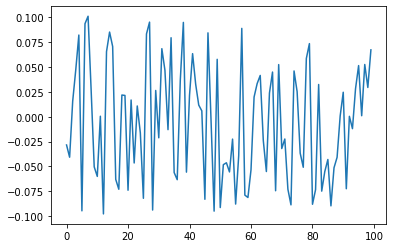

In [157]:
plt.plot([-0.0284, -0.0407,  0.0156,  0.0472,  0.0821, -0.0946,  0.0935,
           0.1010,  0.0268, -0.0504, -0.0600,  0.0005, -0.0977,  0.0654,
           0.0851,  0.0706, -0.0630, -0.0729,  0.0218,  0.0214, -0.0739,
           0.0168, -0.0465,  0.0108, -0.0162, -0.0820,  0.0832,  0.0951,
          -0.0938,  0.0264, -0.0212,  0.0684,  0.0468, -0.0130,  0.0794,
          -0.0561, -0.0633,  0.0367,  0.0948, -0.0557,  0.0215,  0.0634,
           0.0327,  0.0117,  0.0059, -0.0830,  0.0843, -0.0036, -0.0949,
           0.0577, -0.0913, -0.0482, -0.0463, -0.0555, -0.0225, -0.0878,
          -0.0392,  0.0888, -0.0788, -0.0812, -0.0534,  0.0198,  0.0333,
           0.0415, -0.0240, -0.0551,  0.0238,  0.0449, -0.0744,  0.0524,
          -0.0320, -0.0224, -0.0729, -0.0886,  0.0460,  0.0252, -0.0367,
          -0.0508,  0.0586,  0.0735, -0.0880, -0.0733,  0.0324, -0.0748,
          -0.0551, -0.0430, -0.0896, -0.0513, -0.0408,  0.0007,  0.0246,
          -0.0724,  0.0004, -0.0120,  0.0282,  0.0514,  0.0010,  0.0525,
           0.0294,  0.0672])

In [43]:
batch_size_vec = [10, 50, 100, 200]
num_mini_batches = 500
num_epochs = 500
lr_vec = [1e-5, 1e-4, 1e-3]

c = np.zeros((len(lr_vec), len(batch_size_vec)))
for i, lr in enumerate(lr_vec): 
    for j, batch_size in enumerate(batch_size_vec): 
        mi_est_values, clarity_est, x_samples, y_samples = train_model(data=y, lr=lr, batch_size=batch_size, num_epochs=num_epochs, num_mini_batches=num_mini_batches, schedule=schedule)
        c[i, j] = clarity_est[-1]
        

 76%|███████▌  | 378/500 [05:25<01:45,  1.16it/s]


In [44]:
c

array([[0.39616634, 0.37465335, 0.36562905, 0.48290798],
       [0.72401826, 0.38813184, 0.34958785, 0.33636795],
       [0.68639786, 0.35637747, 0.50370962, 0.33844181]])